## Introduction to Google Colab

**Google Colab** (Colaboratory) is a free, cloud-based platform provided by Google that allows you to write and run Python code in your browser.  
It's especially useful for machine learning and data science projects because it provides access to GPUs and TPUs.

#### Features:
- **Free Access to GPUs and TPUs**: You can run your code on powerful hardware accelerators, which is helpful for deep learning tasks.
- **Easy Sharing and Collaboration**: Like Google Docs, Colab lets you share your notebooks with others.
- **No Setup Required**: Since Colab runs in the cloud, you don’t need to install any special software to get started. All you need is a browser.

## Segment Anything Model 2 (SAM 2) Overview
SAM 2 predicts object masks in images based on user prompts.  
First, SAM 2 processes the image into an embedding, which allows it to generate high-quality masks efficiently.  
Prompts can be points, boxes, or masks from previous predictions.  

### Setting Up the Environment
If you're using Google Colab, make sure to select a GPU under 'Edit' -> 'Notebook Settings' -> 'Hardware accelerator'.  
It's recommended to use A100 or L4 GPUs for better performance, but T4 GPUs can work too (though slower).  

In [4]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

using_colab = True

if using_colab:
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA available:", torch.cuda.is_available())

    # Install required libraries
    !pip install opencv-python matplotlib
    !pip install 'git+https://github.com/facebookresearch/sam2.git'
    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/truck.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt

# Use GPU (CUDA) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
CUDA available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-bky_kejq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-bky_kejq
  Resolved https://github.com/facebookresearch/sam2.git to commit 29267c8e3965bb7744a436ab7db555718d20391a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
--2024-10-08 13:52:32--  https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271475 (265K) [image/jpeg]
Saving to: ‘images/truck.jpg.2’

truck.j

### Loading SAM 2
We’ll load SAM 2 and provide an image for the model to process.  
You can select an object in the image by providing point coordinates.

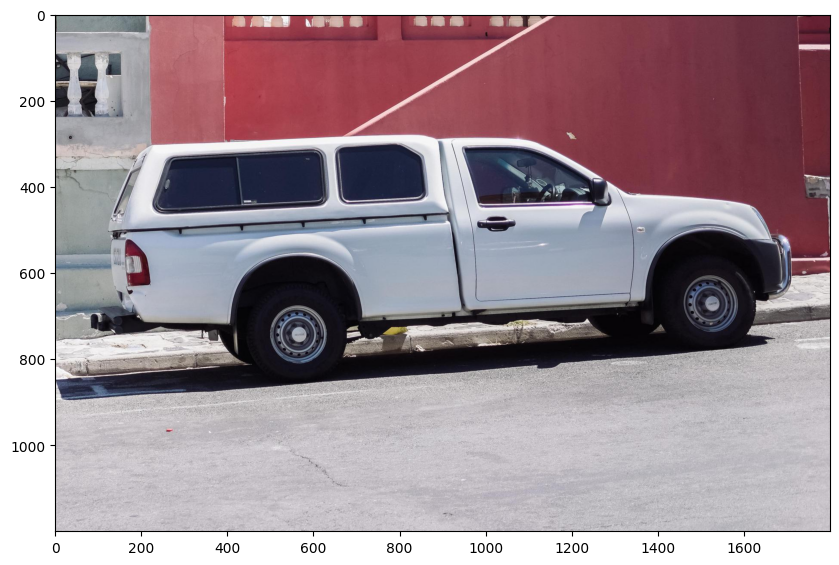

In [5]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Load model
sam2_checkpoint = "../checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

# Load and display an example image
image = Image.open('images/truck.jpg')
image = np.array(image.convert("RGB"))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

# Set the image in the predictor
predictor.set_image(image)

In [8]:
# Helper methods for visualizing masks

np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

### Predicting Object Masks
Now we can give a point prompt (e.g., on the truck) to predict masks.   
SAM 2 will generate three masks, we can visualize all.

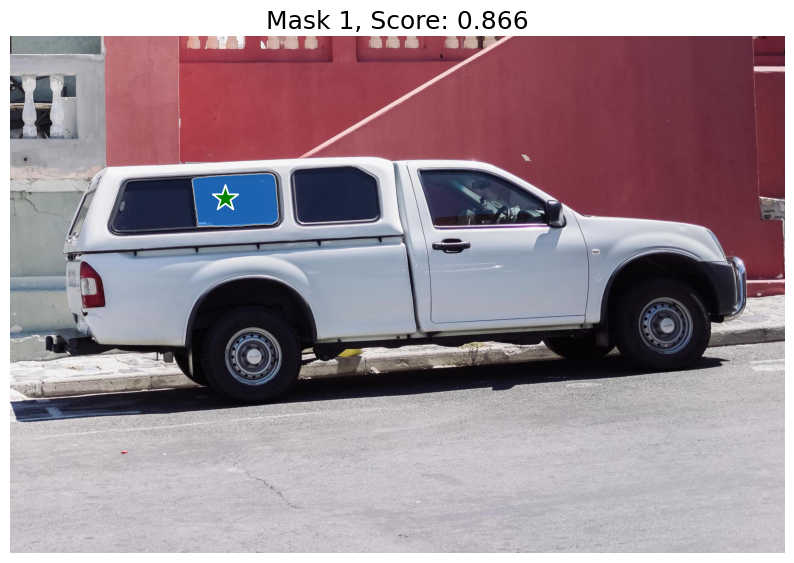

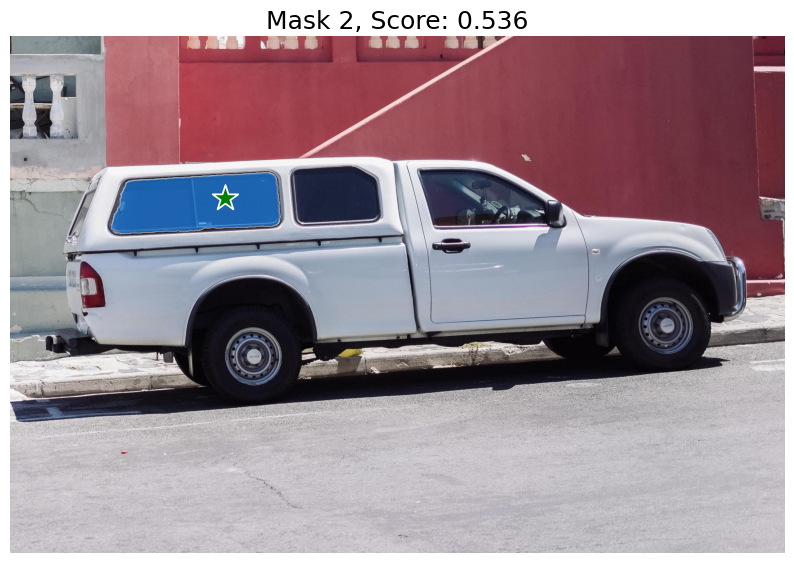

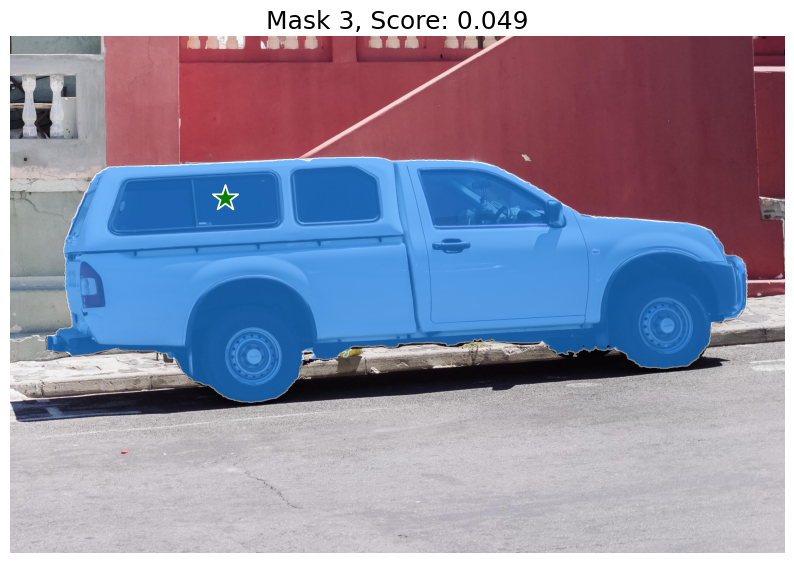

In [9]:
# Provide point prompt
input_point = np.array([[500, 375]])  # Coordinates of the truck window
input_label = np.array([1])  # Label 1 means foreground (object of interest)
                             # Label 0 means background

# Predict masks
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True, # This generates 3 mask options
)

# Sort and select masks
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)